# Setup

## Imports

In [3]:
import pandas as pd
import numpy as np
from fastai.tabular.all import *
import seaborn as sns
import matplotlib.pyplot as plt

## Reading in the data

We start by reading in all the data. The data is in the form of Stata .dta files so we read that in. Additionally I've read in a pdf explaining how the codes relate to questions asked in the verbal autopsy in to a dataframe *questions_df* so we can see what the questions asked are.

In [99]:
deaths_df = pd.read_stata('data/RD0105ACDISDeaths.dta')
deaths_df.rename(columns={'IIntId': 'ID'}, inplace=True)
verbal_autopsy_df = pd.read_stata('data/verbal_autopsy.dta')
verbal_autopsy_df.rename(columns={'iv5_id': 'ID'}, inplace=True)
questions_df = pd.read_csv('data/VerbalAutopsy_extracted_table.csv')
questions_df = questions_df[~questions_df['Code'].str.contains("Verbal", na=False)]

# Merging the verbal autopsy answers with the death certificates
df = pd.merge(deaths_df, verbal_autopsy_df, on='ID', how='inner')

## Inspecting the data

In [18]:
deaths_df.head().T

,0,1,2,3,4
ID,11,12,16,19,20
DateOfDeath,2004-12-12 00:00:00,2006-02-01 00:00:00,2013-01-18 00:00:00,2015-10-14 00:00:00,2005-11-05 00:00:00
IEndInformantId,NaN,42.0,25.0,34.0,16.0
IEndInformantType,_other,Caregiver,Household Member,Household Member,Household Member
DateOfBirth,1945-01-10 00:00:00,1940-12-26 00:00:00,1952-11-16 00:00:00,1939-08-18 00:00:00,1973-06-25 00:00:00
Sex,Male,Female,Female,Female,Female
DeathNotificationDate,2005-04-28 00:00:00,2006-08-02 00:00:00,2013-02-19 00:00:00,2015-11-17 00:00:00,2007-03-26 00:00:00
VisitType,Regular Visit,Unsuccessful Visit,Regular Visit,Regular Visit,Regular Visit
DeathSetting,_don't know,Own Home,Own Home,Own Home,Governmental (public) Hospital
DeathCareProvider,_don't know,Family Member,Family Member,Family Member,_don't know


In [19]:
verbal_autopsy_df.head().T

,0,1,2,3,4
ID,11,12,16,19,20
DoB,1945-01-10 00:00:00,1940-12-26 00:00:00,1952-11-16 00:00:00,1939-08-18 00:00:00,1973-06-25 00:00:00
DoD,2004-12-12 00:00:00,2006-02-01 00:00:00,2013-01-18 00:00:00,2015-10-14 00:00:00,2005-11-05 00:00:00
InterviewDate,2006-02-06 00:00:00,2007-10-10 00:00:00,2013-09-10 00:00:00,2016-02-09 00:00:00,2007-08-27 00:00:00
DeathSetting,Other,Home,Home,Home,Hospital
...,...,...,...,...,...
i455o,No,No,No,No,No
i456o,NaN,NaN,NaN,NaN,NaN
i457o,No,No,No,No,Yes
i458o,NaN,NaN,NaN,NaN,NaN


In [98]:
questions_df.head(20)

,Nr,Code,Label,Type,Format,Valid,Invalid,Question
1,2,DoB,Date of Birth,discrete,character-11,2283,7,-
2,3,DoD,Date of Death,discrete,character-11,2283,7,-
3,4,Intervie,.. Interview Date,discrete,character-11,2282,7,-
4,5,DeathSet,.. Place of death,discrete,numeric-12.0,21385,1452,-
5,6,sv_refer,.. Was the child referred to another place for care?,discrete,numeric-12.0,72,22765,-
6,7,sv_reach,.. Did they reach the place they were referred to?,discrete,numeric-12.0,22,22815,-
7,8,sb_minut,.. How many minutes after birth did the baby first cry?,continuous,numeric-12.0,23,22814,-
8,9,ap_menta,.. For how many months did (s)he have mental confusion?,continuous,numeric-12.0,558,22279,-
9,10,md_preg_,.. Was she pregnant at the time of death?,discrete,numeric-12.0,1514,21323,-
10,11,md_die_d,".. Did she die within 6 weeks of delivery, abortion or miscarriage?",discrete,numeric-12.0,1505,21332,-


We want to look at the Global Burden of Disease group (DeathCauseGBDgroup). There are a number of entries with "unknown entered" as their group and we want to try and predict those.

In [92]:
row = questions_df[questions_df['Code'] == 'i459o']
row

,Nr,Code,Label,Type,Format,Valid,Invalid,Question
384,385,i459o,"Over the course of illness, did the total costs of care and treatment prohibit ot",discrete,numeric-12.0,2947,19890,-


In [93]:
verbal_autopsy_df['i459o']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
21691    Yes
21692    Yes
21693     No
21694     No
21695     No
Name: i459o, Length: 21696, dtype: category
Categories (2, object): ['No' < 'Yes']

In [21]:
df['DeathCauseGBDgroup'].value_counts(dropna=False)

DeathCauseGBDgroup
AIDS_TB     7582
Unknown     7217
NonComm     3363
CMPN        2023
Injuries    1507
Name: count, dtype: int64

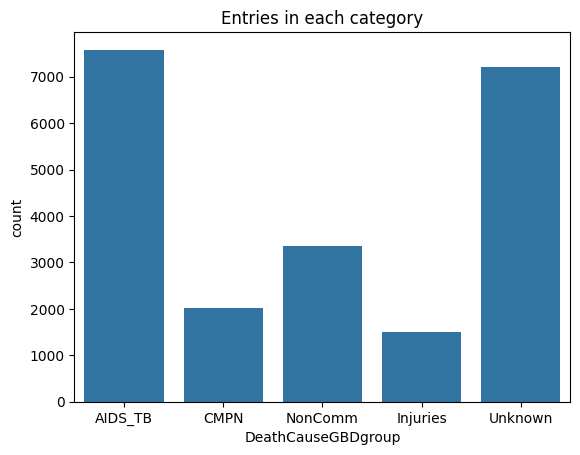

In [28]:
plt.figure()
plt.title('Entries in each category')
sns.countplot(x= df['DeathCauseGBDgroup'],)
plt.show()

## Preparing the data

In [22]:
df['Age'] = (df['DateOfDeath'] - df['DateOfBirth']).dt.days / 365.25
va_cont = ['Age']
va_cat = list(verbal_autopsy_df.columns)
items_to_remove = ['ID', 'DoB', 'DoD', 'InterviewDate', 'DeathSetting']  
va_cat = [item for item in va_cat if item not in items_to_remove]

In [23]:
df_known_gbd = df[df['DeathCauseGBDgroup'] != 'Unknown']
df_unknown_gbd = df[df['DeathCauseGBDgroup'] == 'Unknown']

In [24]:
df_unknown_gbd.head()

,ID,DateOfDeath,IEndInformantId,IEndInformantType,DateOfBirth,Sex,DeathNotificationDate,VisitType,DeathSetting_x,DeathCareProvider,...,i451o,i452o,i453o,i454o,i455o,i456o,i457o,i458o,i459o,Age
2,16,2013-01-18,25.0,Household Member,1952-11-16,Female,2013-02-19,Regular Visit,Own Home,Family Member,...,NaN,NaN,NaN,NaN,No,NaN,No,NaN,NaN,60.172485
3,19,2015-10-14,34.0,Household Member,1939-08-18,Female,2015-11-17,Regular Visit,Own Home,Family Member,...,NaN,NaN,NaN,NaN,No,NaN,No,NaN,NaN,76.156057
5,56,2013-08-03,NaN,Household Head,1953-04-16,Male,2013-11-12,Regular Visit,Governmental (public) Hospital,Nurse / Midwife,...,NaN,NaN,NaN,NaN,No,NaN,No,NaN,NaN,60.298426
12,84,2016-08-27,83.0,Household Member,1983-12-03,Male,2016-11-02,Regular Visit,Governmental (public) Hospital,Nurse / Midwife,...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,32.733744
24,135,2018-05-18,140.0,Household Member,1965-10-23,Male,2018-06-05,Regular Visit,Private Hospital,Nurse / Midwife,...,Yes,No,No,No,No,No,No,Yes,Yes,52.566735


# Training 

In [34]:
dep_var = 'DeathCauseGBDgroup'
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df_known_gbd))
to = TabularPandas(df_known_gbd, procs=procs, cat_names=va_cat, cont_names=va_cont, y_names=dep_var, splits=splits)

In [35]:
dls = to.dataloaders(bs=256)
learn = tabular_learner(dls, metrics=[accuracy])
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.480479,0.964452,0.648014,00:03
1,0.372897,0.368499,0.867357,00:02
2,0.321865,0.391177,0.869430,00:02


Hyperparameters at our disposal
* Learning rate
* Number of epocs of training
* Batch size

## Tweaking the learning rate

/home/carljvh/mambaforge/envs/ahri_env/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location

SuggestedLRs(valley=0.0008317637839354575, slide=0.04786301031708717)

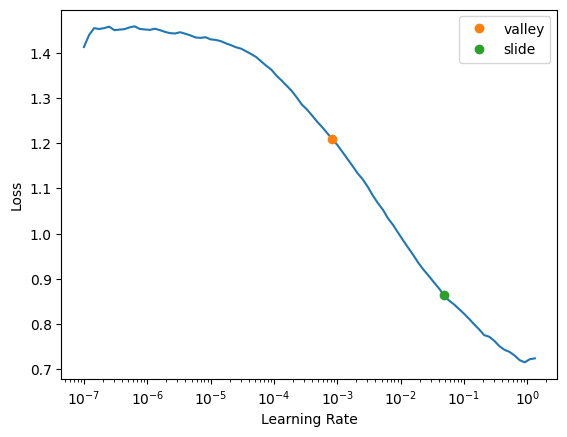

In [37]:
learn = tabular_learner(dls, metrics=[accuracy])
learn.lr_find(suggest_funcs=[valley, slide])

In [39]:
dls = to.dataloaders(bs=256)
learn = tabular_learner(dls, metrics=[accuracy])
learn.fit(3, lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.480624,0.534144,0.815889,00:03
1,0.376116,0.377026,0.865285,00:02
2,0.334496,0.368514,0.867703,00:03


## Tweaking the batch size

In [40]:
dls = to.dataloaders(bs=32)
learn = tabular_learner(dls, metrics=[accuracy])
learn.fit(3, lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.400848,0.399900,0.860104,00:19
1,0.359175,34.340164,0.836960,00:18
2,0.385512,7.131688,0.858722,00:18


In [41]:
dls = to.dataloaders(bs=2056)
learn = tabular_learner(dls, metrics=[accuracy])
learn.fit(3, lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,1.269364,34.317104,0.512263,00:00
1,0.876789,81.239716,0.358549,00:00
2,0.701967,76.796814,0.118135,00:00


In [50]:
dls = to.dataloaders(bs=1028)
learn = tabular_learner(dls, metrics=[accuracy])
learn.fit(20, lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.927859,145.884644,0.508463,00:01
1,0.632860,36.887108,0.508463,00:01
2,0.503498,9.852347,0.508463,00:01
3,0.442195,1.858010,0.616235,00:01
4,0.400540,0.412180,0.855613,00:01
5,0.373084,0.361639,0.866667,00:01
6,0.348361,0.361190,0.868394,00:01
7,0.332741,0.367130,0.864940,00:01
8,0.322161,0.367238,0.868394,00:01
9,0.312985,0.370104,0.867357,00:01


## Using a different model type that increases and decreases the learning rate

The fit_one_cycle() method uses something called *"Super-convergence"* where you start with a very large learning rate, then rapidly reduce the learning rate with the idea of training a model significantly faster. The technique is described in [the paper on Super-Convergence](https://arxiv.org/abs/1708.07120)

In [52]:
dls = to.dataloaders(bs=1028)
learn = tabular_learner(dls, metrics=[accuracy])
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,1.202597,1.380581,0.107772,00:01
1,1.025771,1.399693,0.107772,00:01
2,0.876197,1.388623,0.107772,00:01
3,0.736769,1.259143,0.315371,00:01
4,0.623283,0.988614,0.830743,00:01
5,0.540913,0.728345,0.858722,00:01
6,0.478802,0.513040,0.861485,00:01
7,0.432887,0.404492,0.873575,00:01
8,0.398391,0.371500,0.866667,00:01
9,0.372365,0.355010,0.872193,00:01


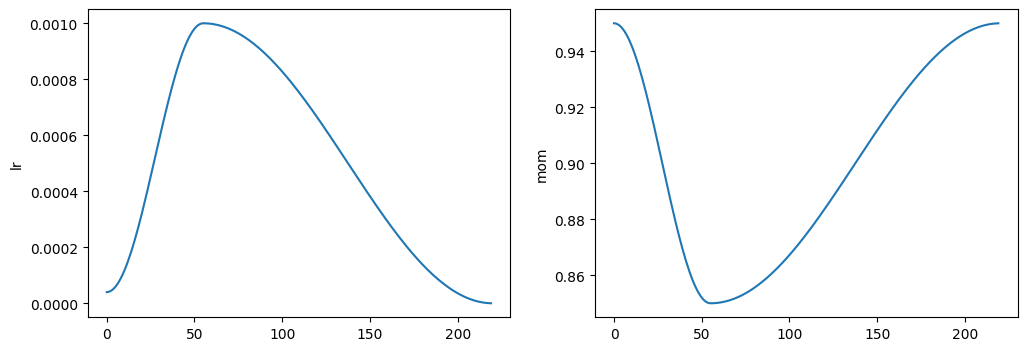

In [53]:
learn.recorder.plot_sched()

## Setting a large number of epochs and allowing the model to stop early

In [47]:
dls = to.dataloaders(bs=1028)

learn = tabular_learner(
    dls, 
    metrics=[accuracy],
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5, min_delta=0.001)]
)

# Train the model with early stopping
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,time
0,1.250064,1.440522,0.107772,00:01
1,1.127060,1.461603,0.107772,00:01
2,1.046433,1.477450,0.107772,00:01
3,0.975688,1.470145,0.115717,00:01
4,0.907320,1.381538,0.289465,00:01
5,0.838972,1.197495,0.562694,00:01
6,0.771354,0.942522,0.752677,00:01
7,0.706937,0.689944,0.835924,00:01
8,0.649598,0.497527,0.854577,00:01
9,0.591265,0.406247,0.861485,00:01


No improvement since epoch 17: early stopping


## Overfitting the model

In [48]:
dls = to.dataloaders(bs=1028)
learn = tabular_learner(dls, metrics=[accuracy])
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,time
0,1.346117,1.373441,0.509154,00:01
1,1.203123,1.353270,0.515026,00:01
2,1.110806,1.329946,0.428670,00:01
3,1.037162,1.298819,0.456995,00:01
4,0.972936,1.240480,0.640760,00:01
5,0.913666,1.140938,0.721934,00:01
6,0.856337,0.999773,0.767876,00:01
7,0.803991,0.830646,0.803109,00:01
8,0.751476,0.673496,0.830397,00:01
9,0.699050,0.551771,0.838342,00:01


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Underfitting the model

In [54]:
dls = to.dataloaders(bs=1028)
learn = tabular_learner(dls, metrics=[accuracy])
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.025111,1.437991,0.235924,00:01
1,0.778022,1.567656,0.235924,00:01


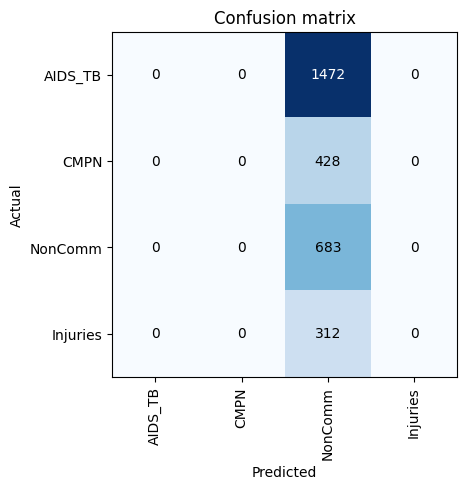

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Looking under the hood at our model

In [60]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1-41): 41 x Embedding(3, 3)
    (42): Embedding(2, 2)
    (43): Embedding(3, 3)
    (44): Embedding(1, 2)
    (45-59): 15 x Embedding(3, 3)
    (60): Embedding(2, 2)
    (61-104): 44 x Embedding(3, 3)
    (105-106): 2 x Embedding(2, 2)
    (107-110): 4 x Embedding(3, 3)
    (111): Embedding(1, 2)
    (112-130): 19 x Embedding(3, 3)
    (131): Embedding(1, 2)
    (132-144): 13 x Embedding(3, 3)
    (145): Embedding(2, 2)
    (146-161): 16 x Embedding(3, 3)
    (162): Embedding(2, 2)
    (163-166): 4 x Embedding(3, 3)
    (167): Embedding(2, 2)
    (168-172): 5 x Embedding(3, 3)
    (173): Embedding(2, 2)
    (174-202): 29 x Embedding(3, 3)
    (203): Embedding(1, 2)
    (204-217): 14 x Embedding(3, 3)
    (218): Embedding(2, 2)
    (219-220): 2 x Embedding(3, 3)
    (221-223): 3 x Embedding(2, 2)
    (224): Embedding(3, 3)
    (225-226): 2 x Embedding(2, 2)
    (227): Embedding(3, 3)
    (228): Embedding(2, 2)
    (229)

Above is the standard architecture for FastAI TabularLearners, there are several notable ideas here:
* This model does not make use of one hot encoding for the categorical variables. See [this paper](https://arxiv.org/abs/1604.06737) for detail on how **"entity embeddings"** work. Basically categorical variables are mapped closer to each other in Euclidean spaces so specific relationships between objects in the category can be captured. This also saves memory and improves speed. This was combined with converting the variables to truly continuous variables see [this paper by the Google Play recommendation team](https://arxiv.org/abs/1606.07792)
* The first **normalisation layer** converts continuous variables to have a mean of 0 and deviation of 1 unit
* Use is made of **dropout**: this is a regularisation technique where a randomly selected fraction of the inputs are set to 0. This prevents overdependence and overfitting as the model cannot rely on any one feature. 
* Note that the humbe **ReLU** function is used in several layers here. This introduces non-linearity to the model and is part of what makes this model "deep learning" proper

# Interpreting results

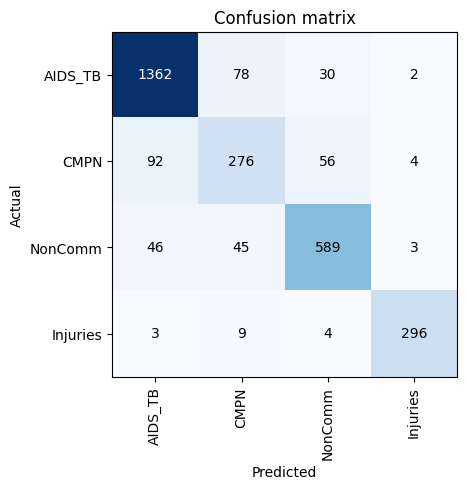

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Making predictions on our unknown dataframe

In [68]:
# Drop the 'DeathCauseGBDgroup' column from df_unknown_gbd
# df_unknown_gbd = df_unknown_gbd.drop(columns=['DeathCauseGBDgroup'])

# Convert df_unknown_gbd to TabularPandas, using the same processing as the training data
to_test = dls.test_dl(df_unknown_gbd)

# Make predictions using the learn object
predictions, probabilities = learn.get_preds(dl=to_test)

# Convert the predictions and probabilities to a human-readable format
predicted_classes = [dls.vocab[pred] for pred in predictions.argmax(dim=1)]

# Add predictions to the original dataframe
df_unknown_gbd['predicted_class'] = predicted_classes

# Optionally, add the probabilities to the dataframe as well
# df_unknown_gbd['probabilities'] = probabilities.tolist()

# Show the dataframe with predictions
df_unknown_gbd.head()

,ID,DateOfDeath,IEndInformantId,IEndInformantType,DateOfBirth,Sex,DeathNotificationDate,VisitType,DeathSetting_x,DeathCareProvider,...,i452o,i453o,i454o,i455o,i456o,i457o,i458o,i459o,Age,predicted_class
2,16,2013-01-18,25.0,Household Member,1952-11-16,Female,2013-02-19,Regular Visit,Own Home,Family Member,...,NaN,NaN,NaN,No,NaN,No,NaN,NaN,60.172485,NonComm
3,19,2015-10-14,34.0,Household Member,1939-08-18,Female,2015-11-17,Regular Visit,Own Home,Family Member,...,NaN,NaN,NaN,No,NaN,No,NaN,NaN,76.156057,NonComm
5,56,2013-08-03,NaN,Household Head,1953-04-16,Male,2013-11-12,Regular Visit,Governmental (public) Hospital,Nurse / Midwife,...,NaN,NaN,NaN,No,NaN,No,NaN,NaN,60.298426,NonComm
12,84,2016-08-27,83.0,Household Member,1983-12-03,Male,2016-11-02,Regular Visit,Governmental (public) Hospital,Nurse / Midwife,...,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,32.733744,NonComm
24,135,2018-05-18,140.0,Household Member,1965-10-23,Male,2018-06-05,Regular Visit,Private Hospital,Nurse / Midwife,...,No,No,No,No,No,No,Yes,Yes,52.566735,NonComm


In [71]:
print(predictions)
print(predictions.shape)

tensor([[0.1315, 0.2304, 0.4306, 0.2075],
        [0.1242, 0.2316, 0.4371, 0.2070],
        [0.1321, 0.2289, 0.4317, 0.2072],
        ...,
        [0.1354, 0.2418, 0.4108, 0.2120],
        [0.1391, 0.2403, 0.4080, 0.2126],
        [0.1357, 0.2434, 0.4100, 0.2110]])
torch.Size([7217, 4])


## Looking up the question for the unknown group

In [100]:
# def extract_answered_questions(questions_df, df_verbal_autopsy, id_value, va_cat):
#     # Ensure id_value is an integer
#     id_value = int(id_value)
    
#     # Find the row in df_verbal_autopsy with the given ID
#     va_row = df_verbal_autopsy.loc[df_verbal_autopsy['ID'] == id_value]
    
#     # Check if the ID exists
#     if va_row.empty:
#         raise ValueError(f"No row found with ID: {id_value}")
    
#     # Ensure we're working with a Series (in case multiple rows match the ID)
#     va_row = va_row.iloc[0]
    
#     # Filter va_row to only include columns in va_cat
#     va_row_filtered = va_row[va_cat]
    
#     # Create a mask for non-NaN values
#     non_nan_mask = ~va_row_filtered.isna()
    
#     # Filter the row to keep only non-NaN values
#     answered = va_row_filtered[non_nan_mask]
    
#     # Create a dataframe with questions and answers
#     result = pd.DataFrame({
#         'Question': questions_df.loc[answered.index, 'Label'],
#         'Answer': answered.values
#     })

In [101]:
# result = extract_answered_questions(questions_df, verbal_autopsy_df, "11", va_cat)
# print(result)

KeyError: "None of [Index(['i004a', 'i004b', 'i019a', 'i019b', 'i022a', 'i022b', 'i022c', 'i022d',\n       'i022e', 'i022f',\n       ...\n       'i370o', 'i371o', 'i372o', 'i373o', 'i411o', 'i413o', 'i418o', 'i425o',\n       'i455o', 'i457o'],\n      dtype='object', length=126)] are in the [index]"

In [87]:
va_row = verbal_autopsy_df.loc[verbal_autopsy_df['ID'] == '11']
print(va_row)


Empty DataFrame
Columns: [ID, DoB, DoD, InterviewDate, DeathSetting, sv_referralanother, sv_reachplace, i004a, i004b, i019a, i019b, i022a, i022b, i022c, i022d, i022e, i022f, i022g, i022h, i022i, i022j, i022k, i022l, i022m, i022n, i059o, i077o, i079o, i082o, i083o, i084o, i085o, i086o, i087o, i089o, i090o, i091o, i092o, i093o, i094o, i095o, i096o, i098o, i099o, i100o, i104o, i105o, i106a, i107o, i108a, i109o, i110o, i111o, i112o, i113o, i114o, i115o, i116o, i120a, i120b, i123o, i125o, i127o, i128o, i129o, i130o, i131o, i132o, i133o, i134o, i135o, i136o, i137o, i138o, i139o, i140o, i141o, i142o, i143o, i144o, i147o, i148a, i148b, i148c, i149o, i150a, i151a, i152o, i153o, i154a, i154b, i155o, i156o, i157o, i158o, i159o, i161a, i165a, i166o, i167a, ...]
Index: []

[0 rows x 360 columns]


In [88]:
verbal_autopsy_df.dtypes

ID                        int32
DoB              datetime64[ns]
DoD              datetime64[ns]
InterviewDate    datetime64[ns]
DeathSetting           category
                      ...      
i455o                  category
i456o                  category
i457o                  category
i458o                  category
i459o                  category
Length: 360, dtype: object

In [81]:
verbal_autopsy_df.head()

,ID,DoB,DoD,InterviewDate,DeathSetting,sv_referralanother,sv_reachplace,i004a,i004b,i019a,...,i450o,i451o,i452o,i453o,i454o,i455o,i456o,i457o,i458o,i459o
0,11,1945-01-10,2004-12-12,2006-02-06,Other,NaN,NaN,Yes,No,Yes,...,NaN,NaN,NaN,NaN,NaN,No,NaN,No,NaN,NaN
1,12,1940-12-26,2006-02-01,2007-10-10,Home,NaN,NaN,Yes,No,No,...,NaN,NaN,NaN,NaN,NaN,No,NaN,No,NaN,NaN
2,16,1952-11-16,2013-01-18,2013-09-10,Home,NaN,NaN,Yes,No,No,...,NaN,NaN,NaN,NaN,NaN,No,NaN,No,NaN,NaN
3,19,1939-08-18,2015-10-14,2016-02-09,Home,NaN,NaN,No,Yes,No,...,NaN,NaN,NaN,NaN,NaN,No,NaN,No,NaN,NaN
4,20,1973-06-25,2005-11-05,2007-08-27,Hospital,NaN,NaN,Yes,No,No,...,NaN,NaN,NaN,NaN,NaN,No,NaN,Yes,NaN,NaN


# Comparing with a different model - XGBoost

In [59]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Extract training and validation data from the TabularPandas object
X_train, y_train = to.train.xs, to.train.y
X_valid, y_valid = to.valid.xs, to.valid.y

# Train the XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on both training and validation sets
y_train_pred = xgb_model.predict(X_train)
y_valid_pred = xgb_model.predict(X_valid)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Evaluate the model on the validation set
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred, average='weighted')
valid_recall = recall_score(y_valid, y_valid_pred, average='weighted')
valid_f1 = f1_score(y_valid, y_valid_pred, average='weighted')

# Print metrics for training set
print(f"Training Set Metrics:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

# Print metrics for validation set
print(f"\nValidation Set Metrics:")
print(f"Accuracy: {valid_accuracy}")
print(f"Precision: {valid_precision}")
print(f"Recall: {valid_recall}")
print(f"F1 Score: {valid_f1}")

# Print confusion matrix for validation set
print("\nConfusion Matrix for Validation Set:")
print(confusion_matrix(y_valid, y_valid_pred))

Training Set Metrics:
Accuracy: 0.9375647668393783
Precision: 0.9371391239407867
Recall: 0.9375647668393783
F1 Score: 0.9372781174954046

Validation Set Metrics:
Accuracy: 0.8721934369602763
Precision: 0.8705397955845516
Recall: 0.8721934369602763
F1 Score: 0.8712720698675451

Confusion Matrix for Validation Set:
[[1362   84   25    1]
 [  86  275   61    6]
 [  45   40  592    6]
 [   3    8    5  296]]


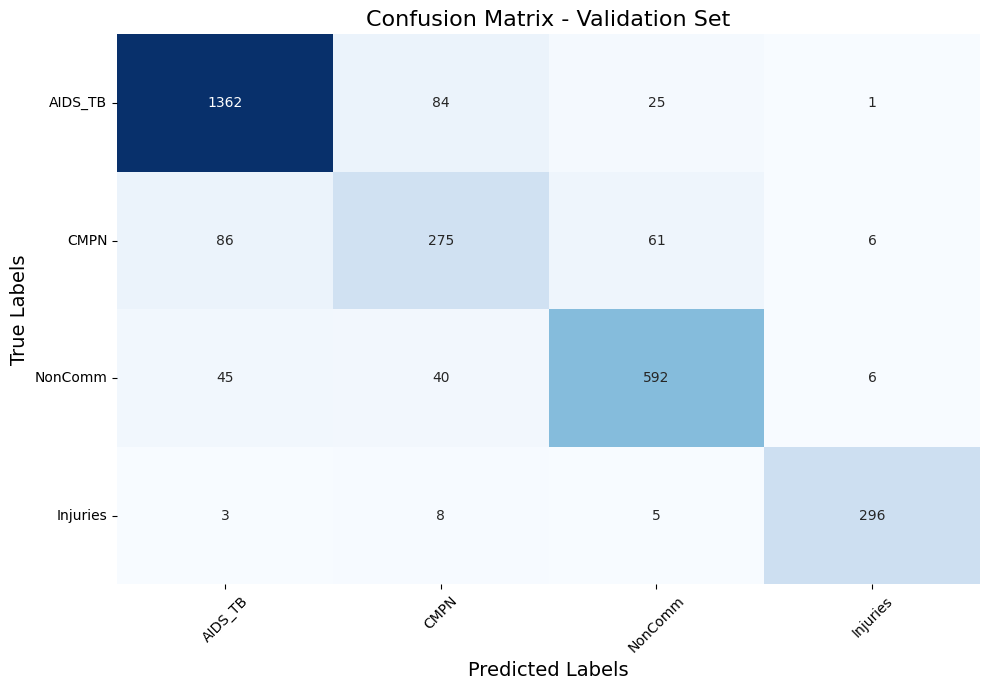

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assume 'dls' is your DataLoader and 'vocab' contains the class names
class_labels = dls.vocab  # Extract vocab (class names) from the DataLoader

# Compute confusion matrix for validation set
cm = confusion_matrix(y_valid, y_valid_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - Validation Set', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()